In [1]:
from kafka import KafkaConsumer, KafkaAdminClient
from kafka.structs import TopicPartition
from json import loads
from time import sleep
from IPython.display import Image

# What is Apache Kafka?

Apache Kafka is a distributed data store optimized for ingesting and processing streaming data in real-time. Streaming data is data that is continuously generated by thousands of data sources, which typically send the data records in simultaneously. A streaming platform needs to handle this constant influx of data, and process the data sequentially and incrementally.

Kafka provides three main functions to its users:

* Publish and subscribe to streams of records
* Effectively store streams of records in the order in which records were generated
* Process streams of records in real time

Kafka is primarily used to build real-time streaming data pipelines and applications that adapt to the data streams. It combines messaging, storage, and stream processing to allow storage and analysis of both historical and real-time data.  

Source: https://aws.amazon.com/msk/what-is-kafka/

# How does Kafka work?

Kafka combines two messaging models, queuing and publish-subscribe, to provide the key benefits of each to consumers. Queuing allows for data processing to be distributed across many consumer instances, making it highly scalable. However, traditional queues aren’t multi-subscriber. The publish-subscribe approach is multi-subscriber, but because every message goes to every subscriber it cannot be used to distribute work across multiple worker processes. Kafka uses a partitioned log model to stitch together these two solutions. A log is an ordered sequence of records, and these logs are broken up into segments, or partitions, that correspond to different subscribers. This means that there can be multiple subscribers to the same topic and each is assigned a partition to allow for higher scalability. Finally, Kafka’s model provides replayability, which allows multiple independent applications reading from data streams to work independently at their own rate.

Source: https://aws.amazon.com/msk/what-is-kafka/

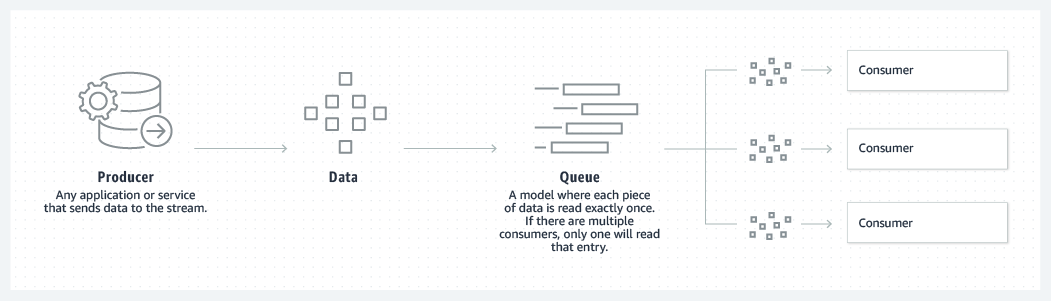

In [3]:
Image(filename='./static/product-page-diagram_Kafka_Queue.png')

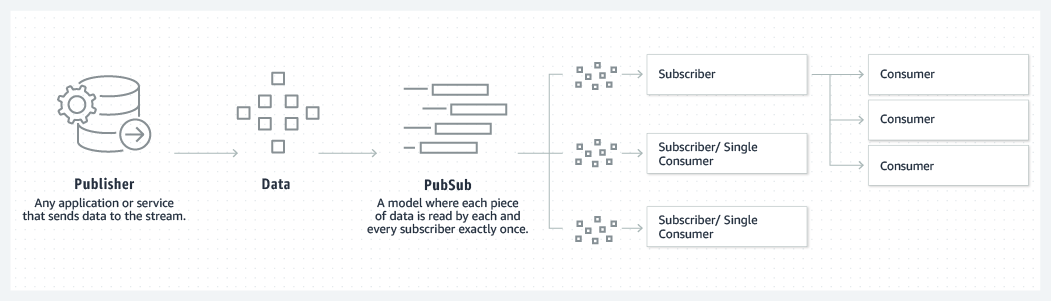

In [4]:
Image(filename='./static/product-page-diagram_Kafka_PubSub.png') 

Kafka is a distributed system consisting of servers and clients that communicate via a high-performance TCP network protocol. It can be deployed on bare-metal hardware, virtual machines, and containers in on-premise as well as cloud environments.

**Servers**: Kafka is run as a cluster of one or more servers that can span multiple datacenters or cloud regions. Some of these servers form the storage layer, called the brokers. Other servers run Kafka Connect to continuously import and export data as event streams to integrate Kafka with your existing systems such as relational databases as well as other Kafka clusters. To let you implement mission-critical use cases, a Kafka cluster is highly scalable and fault-tolerant: if any of its servers fails, the other servers will take over their work to ensure continuous operations without any data loss.

**Clients**: They allow you to write distributed applications and microservices that read, write, and process streams of events in parallel, at scale, and in a fault-tolerant manner even in the case of network problems or machine failures. Kafka ships with some such clients included, which are augmented by dozens of clients provided by the Kafka community: clients are available for Java and Scala including the higher-level Kafka Streams library, for Go, Python, C/C++, and many other programming languages as well as REST APIs.

Source: https://kafka.apache.org/intro

# Main Concepts and Terminology

An **event** records the fact that "something happened" in the world or in your business. It is also called record or message in the documentation. When you read or write data to Kafka, you do this in the form of events. Conceptually, an event has a key, value, timestamp, and optional metadata headers. Here's an example event:

* Event key: "Alice"
* Event value: "Made a payment of $200 to Bob"
* Event timestamp: "Jun. 25, 2020 at 2:06 p.m."

**Producers** are those client applications that publish (write) events to Kafka, and **consumers** are those that subscribe to (read and process) these events. In Kafka, producers and consumers are fully decoupled and agnostic of each other, which is a key design element to achieve the high scalability that Kafka is known for. For example, producers never need to wait for consumers. Kafka provides various guarantees such as the ability to process events exactly-once.

Events are organized and durably stored in **topics**. Very simplified, a topic is similar to a folder in a filesystem, and the events are the files in that folder. An example topic name could be "payments". Topics in Kafka are always multi-producer and multi-subscriber: a topic can have zero, one, or many producers that write events to it, as well as zero, one, or many consumers that subscribe to these events. Events in a topic can be read as often as needed—unlike traditional messaging systems, events are not deleted after consumption. Instead, you define for how long Kafka should retain your events through a per-topic configuration setting, after which old events will be discarded. Kafka's performance is effectively constant with respect to data size, so storing data for a long time is perfectly fine.

Topics are **partitioned**, meaning a topic is spread over a number of "buckets" located on different Kafka brokers. This distributed placement of your data is very important for scalability because it allows client applications to both read and write the data from/to many brokers at the same time. When a new event is published to a topic, it is actually appended to one of the topic's partitions. Events with the same event key (e.g., a customer or vehicle ID) are written to the same partition, and Kafka guarantees that any consumer of a given topic-partition will always read that partition's events in exactly the same order as they were written.

Source: https://kafka.apache.org/intro

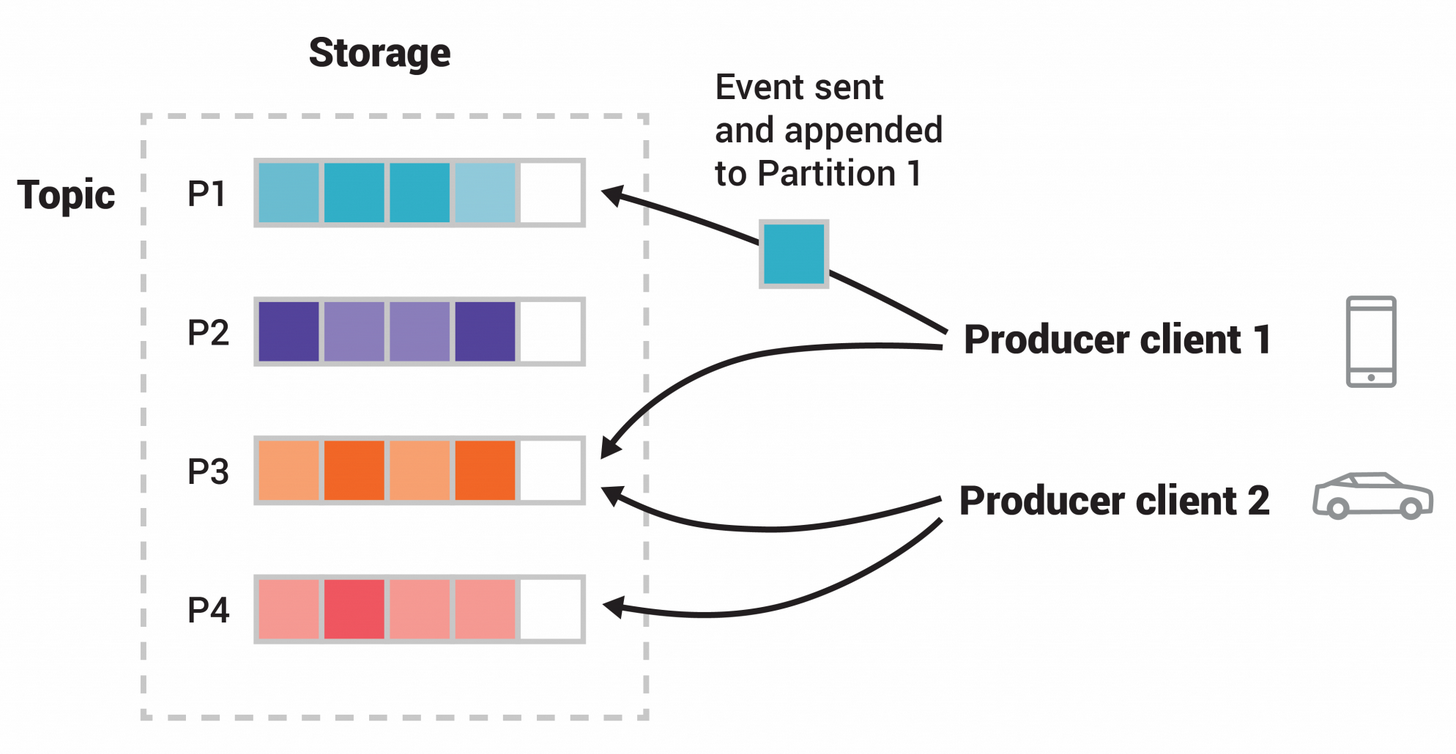

In [5]:
Image(filename='./static/streams-and-tables-p1_p4.png') 

To make your data fault-tolerant and highly-available, every topic can be **replicated**, even across geo-regions or datacenters, so that there are always multiple brokers that have a copy of the data just in case things go wrong, you want to do maintenance on the brokers, and so on. A common production setting is a replication factor of 3, i.e., there will always be three copies of your data. This replication is performed at the level of topic-partitions.


In the cell below we are defining a KafkaConsumer that contacts the server `kafka_broker:9093` and is subscribed to the topic `simple_topic`. Since in the producer script the message is jsonfied and encoded, here we decode it by using a lambda function in value_deserializer.

* `auto_offset_reset` is a parameter that sets the policy for resetting offsets on OffsetOutOfRange errors; if you set `earliest` then it will move to the oldest available message, if `latest` is set then it will move to the most recent;
* `enable_auto_commit` is a boolean parameter that states whether the offset will be periodically committed in the background;
* `group_id` is the name of the consumer group to join.

## 0. Throughout the tutorial we will use KafkaAdminClient to monitor state of the cluster.

https://kafka-python.readthedocs.io/en/master/apidoc/KafkaAdminClient.html

In [2]:
admin_client = KafkaAdminClient(bootstrap_servers=['kafka_broker:9093'])

In [4]:
admin_client.describe_consumer_groups(group_ids=['my-group-id', 'multiple-consumers-group'])

[GroupInformation(error_code=0, group='my-group-id', state='Dead', protocol_type='', protocol='', members=[], authorized_operations=None),
 GroupInformation(error_code=0, group='multiple-consumers-group', state='Dead', protocol_type='', protocol='', members=[], authorized_operations=None)]

As you can see topics we created are present on the cluster but consumer groups for those topics are empty(`members=[]`).

## 1. Before running cells below execute cells up to `2. Single producer - multiple consumers` in the `kafka_producers` notebook.

In [5]:
consumer = KafkaConsumer(
    'simple_topic',
    bootstrap_servers=['kafka_broker:9093'],
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    group_id='my-group-id',
    value_deserializer=lambda x: loads(x.decode('utf-8'))
)

In [6]:
for _idx, event in enumerate(consumer):
    event_data = event.value
    # Do whatever you want
    print(event_data)
    if _idx == 9:
        break

{'random_value': 1825}
{'random_value': 4507}
{'random_value': 3658}
{'random_value': 1680}
{'random_value': 9675}
{'random_value': 521}
{'random_value': 1536}
{'random_value': 3812}
{'random_value': 9196}
{'random_value': 8929}


The consumer group was automatically activated through the use of `for ... in consumer` syntax. We can now verify it:

In [7]:
admin_client.list_consumer_groups()

[('my-group-id', 'consumer')]

In [8]:
admin_client.describe_consumer_groups(group_ids=['my-group-id'])

[GroupInformation(error_code=0, group='my-group-id', state='Stable', protocol_type='consumer', protocol='range', members=[MemberInformation(member_id='kafka-python-2.0.2-b6907919-ea2f-4053-b395-f16e0c666385', client_id='kafka-python-2.0.2', client_host='/172.30.0.3', member_metadata=ConsumerProtocolMemberMetadata(version=0, subscription=['simple_topic'], user_data=b''), member_assignment=ConsumerProtocolMemberAssignment(version=0, assignment=[(topic='simple_topic', partitions=[0])], user_data=b''))], authorized_operations=None)]

The consumer now has a partition assigned. And since we already read from the queue a non-zero offset as well.

In [9]:
for topicPartition in consumer.assignment():
    print(topicPartition)
    print('Previous offset: ', consumer.position(topicPartition))

TopicPartition(topic='simple_topic', partition=0)
Previous offset:  10


As you can see we generated 20 values with the producer but only consumed 10 of them. Let's see what happens if we continue.

In [10]:
for _idx, event in enumerate(consumer):
    event_data = event.value
    # Do whatever you want
    print(event_data)
    if _idx == 9:
        break

{'random_value': 3612}
{'random_value': 9655}
{'random_value': 107}
{'random_value': 6925}
{'random_value': 4553}
{'random_value': 3528}
{'random_value': 1675}
{'random_value': 6225}
{'random_value': 5882}
{'random_value': 9892}


The consumer picked up right up where we left it.

We can check and see what is the current offset for the consumer. We might as well set it to 5.

In [11]:
for topicPartition in consumer.assignment():
    print(topicPartition)
    print('Previous offset: ', consumer.position(topicPartition))
    consumer.seek(topicPartition, 5)
    print('New offset: ', consumer.position(topicPartition))

TopicPartition(topic='simple_topic', partition=0)
Previous offset:  20
New offset:  5


Now that the consumer is set to a smaller offset we can process those messages we have already read. 

The code below will not finish execution as the consumer is waiting for new input from the queue. You might run the producer once again or simply interrupt execution.

In [12]:
for event in consumer:
    event_data = event.value
    print(event_data)

{'random_value': 521}
{'random_value': 1536}
{'random_value': 3812}
{'random_value': 9196}
{'random_value': 8929}
{'random_value': 3612}
{'random_value': 9655}
{'random_value': 107}
{'random_value': 6925}
{'random_value': 4553}
{'random_value': 3528}
{'random_value': 1675}
{'random_value': 6225}
{'random_value': 5882}
{'random_value': 9892}
{'random_value': 1825}
{'random_value': 4507}
{'random_value': 3658}
{'random_value': 1680}
{'random_value': 9675}
{'random_value': 521}
{'random_value': 1536}
{'random_value': 3812}
{'random_value': 9196}
{'random_value': 8929}
{'random_value': 3612}
{'random_value': 9655}
{'random_value': 107}
{'random_value': 6925}
{'random_value': 4553}
{'random_value': 3528}
{'random_value': 1675}
{'random_value': 6225}
{'random_value': 5882}
{'random_value': 9892}


KeyboardInterrupt: 

## 2. Multiple Consumers

In this part we are going to see how to use Kafka with multiple consumer as a queue which basically means that every message will only be consumed once.

Instead of using the `for ... in` syntax you are going to manually subscribe to a specific partition withing a topic.

In [13]:
ensemble_consumer_0 = KafkaConsumer(
    bootstrap_servers=['kafka_broker:9093'],
    client_id = 'ensemble_consumer_0',
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    group_id='multiple-consumers-group',
    value_deserializer=lambda x: loads(x.decode('utf-8'))
)

ensemble_consumer_1 = KafkaConsumer(
    bootstrap_servers=['kafka_broker:9093'],
    client_id = 'ensemble_consumer_1',
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    group_id='multiple-consumers-group',
    value_deserializer=lambda x: loads(x.decode('utf-8'))
)

Our new consumers don't have any partition assigned so we have to do that manually.

In [14]:
len(ensemble_consumer_0.assignment())

0

In [15]:
len(ensemble_consumer_1.assignment())

0

https://kafka-python.readthedocs.io/en/master/apidoc/KafkaConsumer.html#kafka.KafkaConsumer.assign

Note that:

* Manual topic assignment through this method does not use the consumer’s group management functionality. As such, there will be no rebalance operation triggered when group membership or cluster and topic metadata change.

In [29]:
topic_partition = TopicPartition(topic='multiple_consumers_topic', partition=0)

In [17]:
ensemble_consumer_0.assign([topic_partition])
ensemble_consumer_1.assign([topic_partition])

In [27]:
admin_client.describe_consumer_groups(group_ids=['multiple_consumers_group'])

[GroupInformation(error_code=0, group='multiple_consumers_group', state='Dead', protocol_type='', protocol='', members=[], authorized_operations=None)]

Before executing this cell run cells under `2. Single producer - multiple consumers` in the `kafka_producers` notebook.

Let's see how a full record looks.

In [28]:
ensemble_consumer_0.poll(timeout_ms=50, max_records=1)

{TopicPartition(topic='multiple_consumers_topic', partition=0): [ConsumerRecord(topic='multiple_consumers_topic', partition=0, offset=2, timestamp=1611405326030, timestamp_type=0, key=None, value={'random_value': 5453}, headers=[], checksum=None, serialized_key_size=-1, serialized_value_size=22, serialized_header_size=-1)]}

The important thing to note here is that as we consume events with either consumer the offset only changes for the one that processed the event. It means that multiple consumers can independently work through the partition. This is an example for the `PubSub` model.

In [30]:
for topicPartition in ensemble_consumer_0.assignment():
    print('ensemble_consumer_0 offset: ', ensemble_consumer_0.position(topicPartition))
for topicPartition in ensemble_consumer_1.assignment():
    print('ensemble_consumer_1 offset: ', ensemble_consumer_1.position(topicPartition))

ensemble_consumer_0 offset:  3
ensemble_consumer_1 offset:  1


Now let's try the other one.

In [31]:
ensemble_consumer_1.poll(timeout_ms=50, max_records=1)

{TopicPartition(topic='multiple_consumers_topic', partition=0): [ConsumerRecord(topic='multiple_consumers_topic', partition=0, offset=1, timestamp=1611405326030, timestamp_type=0, key=None, value={'random_value': 9355}, headers=[], checksum=None, serialized_key_size=-1, serialized_value_size=22, serialized_header_size=-1)]}

In [32]:
for topicPartition in ensemble_consumer_0.assignment():
    print('ensemble_consumer_0 offset: ', ensemble_consumer_0.position(topicPartition))

for topicPartition in ensemble_consumer_1.assignment():
    print('ensemble_consumer_1 offset: ', ensemble_consumer_1.position(topicPartition))

ensemble_consumer_0 offset:  3
ensemble_consumer_1 offset:  2


In [ ]:
The benefit of using 

In [33]:
for _idx in range(9):
    value0 = ensemble_consumer_0.poll(timeout_ms=50, max_records=1).get(topic_partition)[0].value
    value1 = ensemble_consumer_1.poll(timeout_ms=50, max_records=1).get(topic_partition)[0].value
    print('ensemble_consumer_0', value0)
    print('ensemble_consumer_1', value1)

ensemble_consumer_0 {'random_value': 5896}
ensemble_consumer_1 {'random_value': 5453}
ensemble_consumer_0 {'random_value': 6416}
ensemble_consumer_1 {'random_value': 5896}
ensemble_consumer_0 {'random_value': 5979}
ensemble_consumer_1 {'random_value': 6416}
ensemble_consumer_0 {'random_value': 6972}
ensemble_consumer_1 {'random_value': 5979}
ensemble_consumer_0 {'random_value': 1071}
ensemble_consumer_1 {'random_value': 6972}
ensemble_consumer_0 {'random_value': 6613}
ensemble_consumer_1 {'random_value': 1071}
ensemble_consumer_0 {'random_value': 5093}
ensemble_consumer_1 {'random_value': 6613}
ensemble_consumer_0 {'random_value': 5787}
ensemble_consumer_1 {'random_value': 5093}
ensemble_consumer_0 {'random_value': 7552}
ensemble_consumer_1 {'random_value': 5787}
